In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import uniform, norm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import CategoricalNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from XLB import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_all(filename_train,filename_val,selector,model_selector,name=""):
    # extract data from files
    x_train, y_train = extract_data(filename_train)
    x_val, y_val = extract_data(filename_val)

    # scale data values
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)

    # feature selection
    feat_sel = VarianceThreshold()
    x_train = feat_sel.fit_transform(x_train)
    x_train = selector.fit_transform(x_train,y_train)
    x_val = selector.transform(feat_sel.transform(x_val))
    
    rand_seed = 3454132

    oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
    x_smote, y_smote = oversampler.fit_resample(x_train,y_train)
#     print(x_smote.shape,y_smote.shape)

    oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
    x_os, y_os = oversampler.fit_resample(x_train,y_train)
#     print(x_os.shape,y_os.shape)
    print("{} Results:".format(name))
    print_res("Vanilla",x_train,y_train,model_selector)
    test_res("Vanilla",x_val,y_val,model_selector)
    print_res("Random Oversampling",x_os,y_os,model_selector)
    test_res("Random Oversampling",x_val,y_val,model_selector)
    print_res("SMOTE",x_smote,y_smote,model_selector)
    test_res("SMOTE",x_val,y_val,model_selector)
    

chi2 Results:
Best Score: 0.2717
alpha => 0.9867254431113628
fit_prior => True
norm => True
Splits: 5
Vanilla Train Accuracy: 33.6658%
Vanilla Validation Accuracy: 19.05%
Vanilla F1-score: 0.11
Best Score: 0.2747
alpha => 0.2557277072168217
fit_prior => False
norm => False
Splits: 5
Random Oversampling Train Accuracy: 30.9333%
Random Oversampling Validation Accuracy: 14.29%
Random Oversampling F1-score: 0.06
Best Score: 0.2813
alpha => 0.0985373567512422
fit_prior => False
norm => False
Splits: 5
SMOTE Train Accuracy: 34.0000%
SMOTE Validation Accuracy: 23.81%
SMOTE F1-score: 0.15
f_classif Results:
Best Score: 0.2966
alpha => 0.8601802271579316
fit_prior => False
norm => True
Splits: 5
Vanilla Train Accuracy: 33.1671%
Vanilla Validation Accuracy: 19.05%
Vanilla F1-score: 0.11
Best Score: 0.3000
alpha => 0.2557277072168217
fit_prior => False
norm => False
Splits: 5
Random Oversampling Train Accuracy: 34.1333%
Random Oversampling Validation Accuracy: 14.29%
Random Oversampling F1-score:

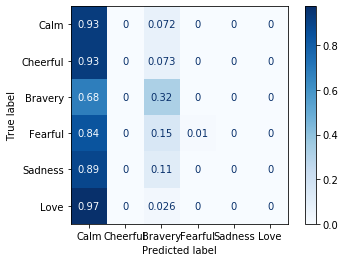

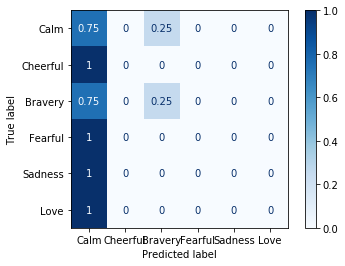

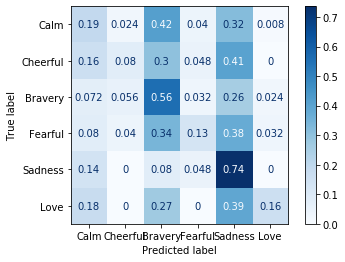

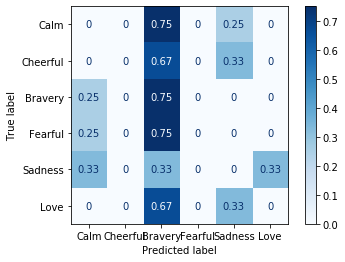

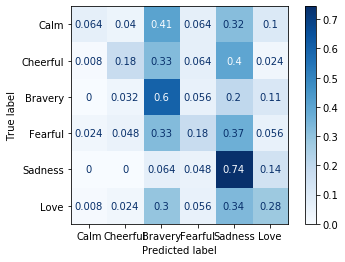

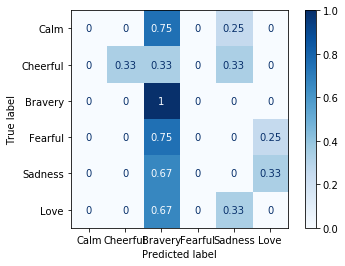

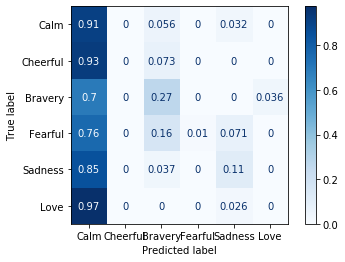

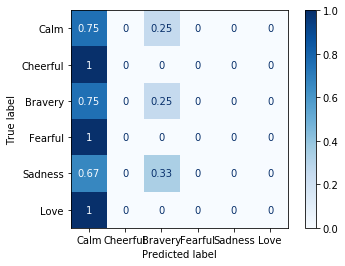

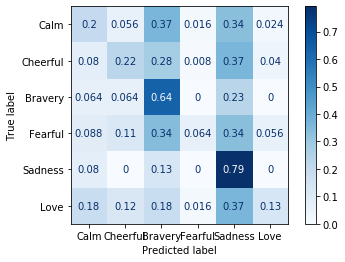

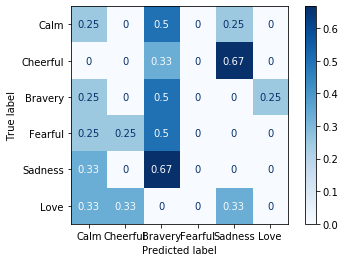

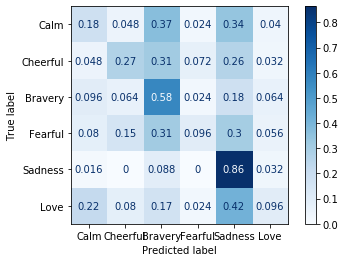

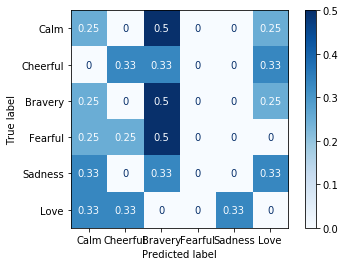

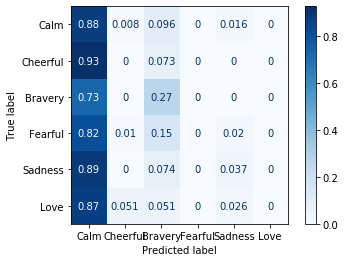

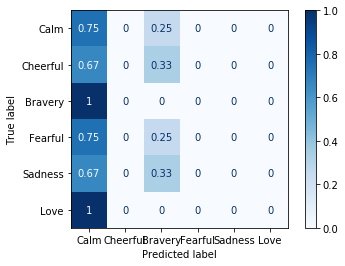

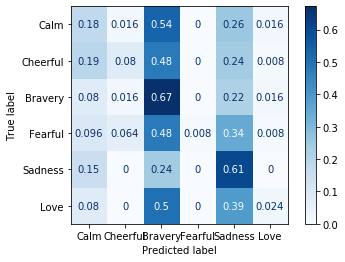

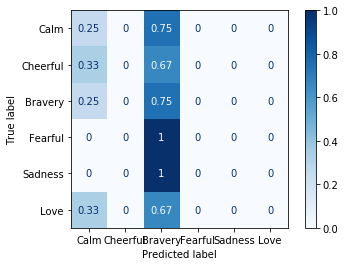

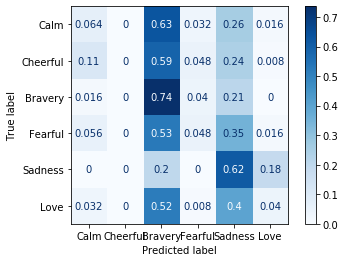

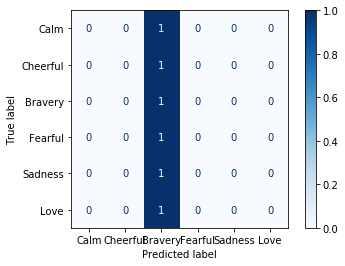

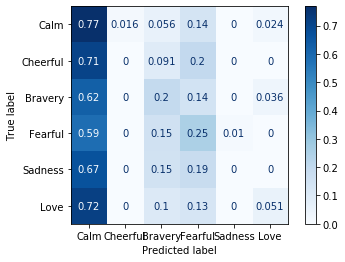

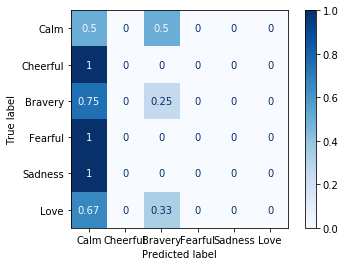

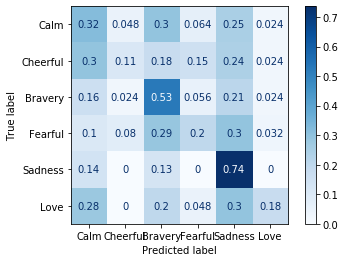

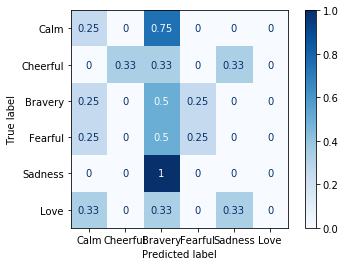

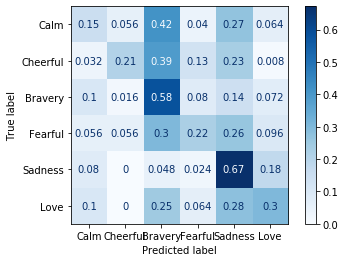

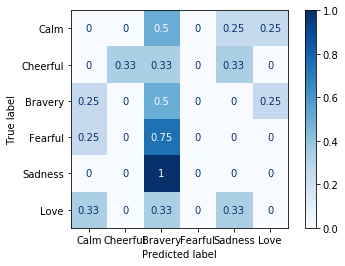

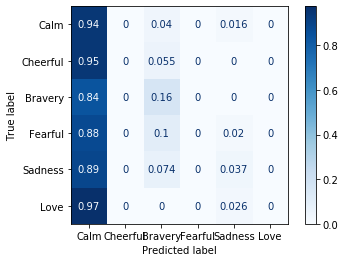

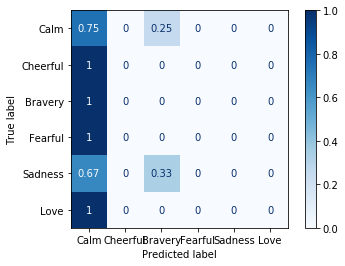

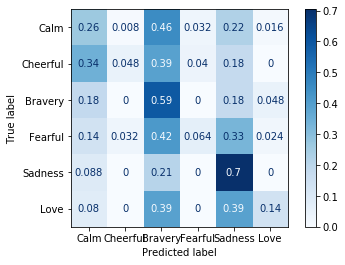

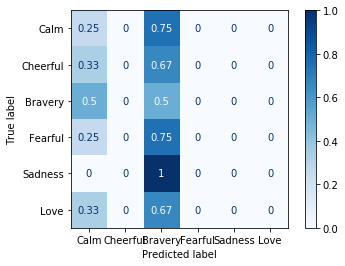

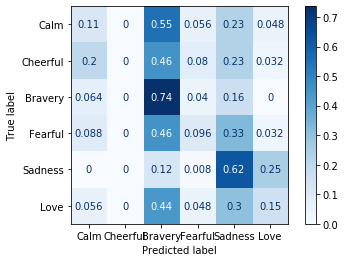

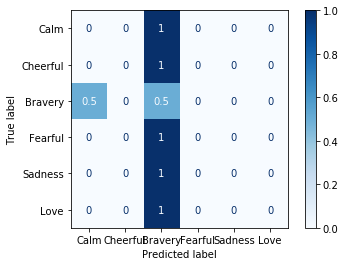

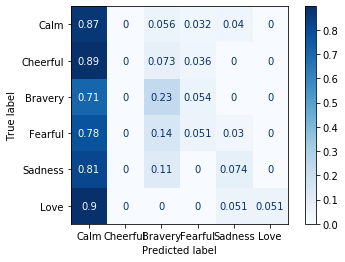

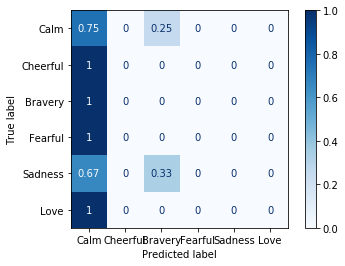

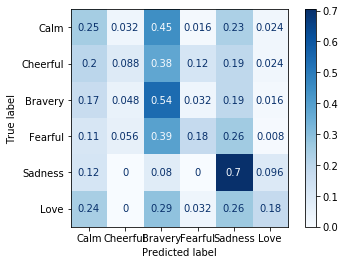

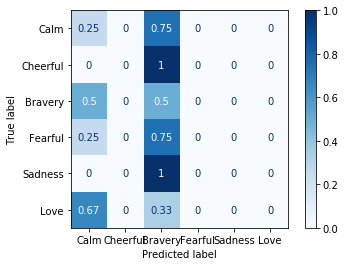

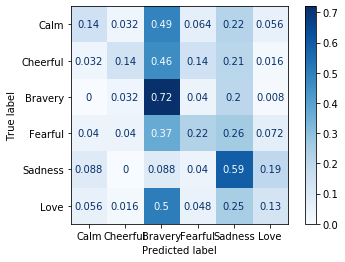

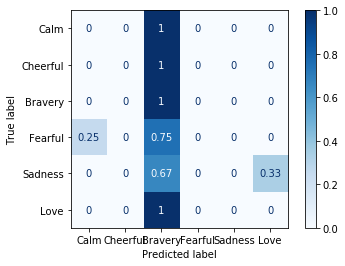

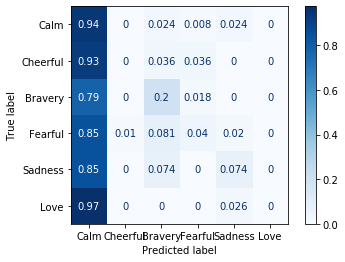

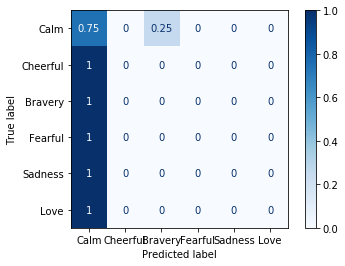

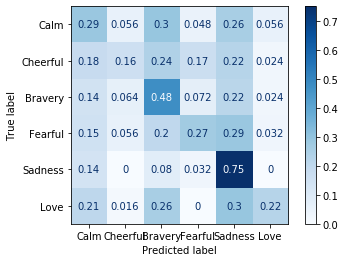

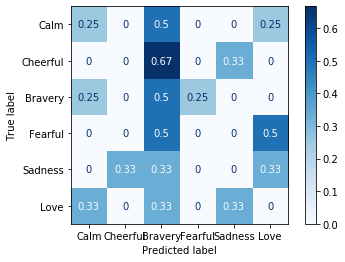

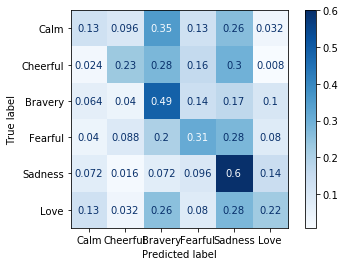

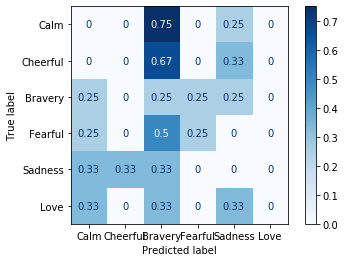

In [8]:
num_features = 45
selectors = {
    "chi2" : SelectKBest(chi2,k=num_features),
    "f_classif" : SelectKBest(f_classif,k=num_features),
    "mutual_info_classif" : SelectKBest(mutual_info_classif,k=num_features),
    "FromModel DT" : SelectFromModel(estimator=tree.DecisionTreeClassifier(random_state=481516234)),
    "RandForest" : SelectFromModel(estimator=RandomForestClassifier(n_estimators=100,random_state=481516234)),
    "LogReg" : SelectFromModel(estimator=LogisticRegression(random_state=481516234)),
    "LinearSVC" : SelectFromModel(estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,random_state=481516234)),
}
# ComplementNB, RandomizedSearch
random_search_iterations = 1000
k_folds = 5
rand_seed = 3249807

parameters = {
    'alpha':uniform(loc=0,scale=1.0), 
    'fit_prior':[True, False], 
    'norm' : [True, False]
}
cnb = ComplementNB()
random_search_complement = RandomizedSearchCV(cnb, parameters,cv=k_folds,\
                                              n_iter=random_search_iterations,\
                                              random_state=rand_seed,n_jobs=-1)
for k,v in selectors.items():
    train_all("FinalTrainingSet.csv","Validation Set.csv",v,random_search_complement,k)


chi2 Results:
Best Score: 0.2917
alpha => 0.25809667965735517
fit_prior => True
Splits: 5
Vanilla Train Accuracy: 35.4115%
Vanilla Validation Accuracy: 19.05%
Vanilla F1-score: 0.11
Best Score: 0.2973
alpha => 0.6055470495258635
fit_prior => False
Splits: 5
Random Oversampling Train Accuracy: 34.0000%
Random Oversampling Validation Accuracy: 14.29%
Random Oversampling F1-score: 0.13
Best Score: 0.2973
alpha => 0.006309627864128364
fit_prior => True
Splits: 5
SMOTE Train Accuracy: 34.8000%
SMOTE Validation Accuracy: 14.29%
SMOTE F1-score: 0.10
f_classif Results:
Best Score: 0.3116
alpha => 0.9895026653079263
fit_prior => True
Splits: 5
Vanilla Train Accuracy: 34.4140%
Vanilla Validation Accuracy: 9.52%
Vanilla F1-score: 0.04
Best Score: 0.3120
alpha => 0.9868336008547082
fit_prior => False
Splits: 5
Random Oversampling Train Accuracy: 35.8667%
Random Oversampling Validation Accuracy: 14.29%
Random Oversampling F1-score: 0.11
Best Score: 0.3067
alpha => 0.4722677282464799
fit_prior => Tr

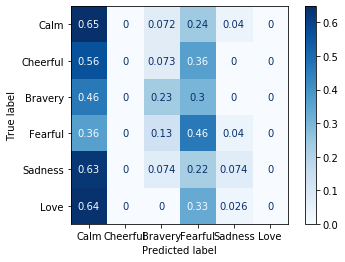

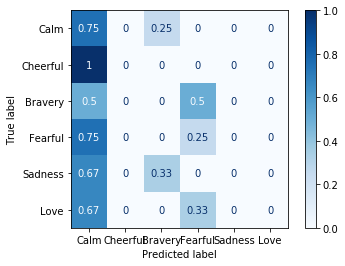

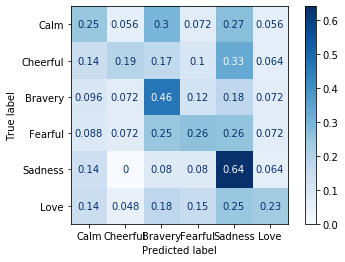

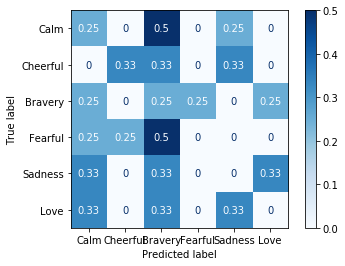

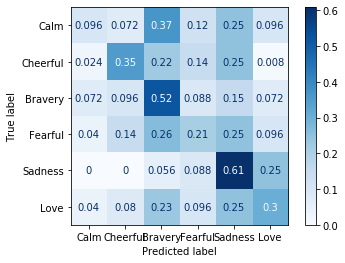

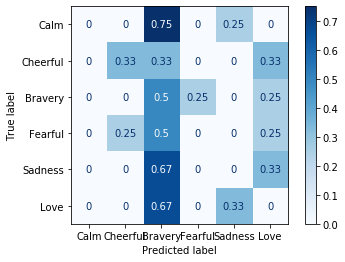

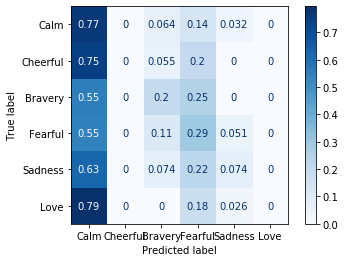

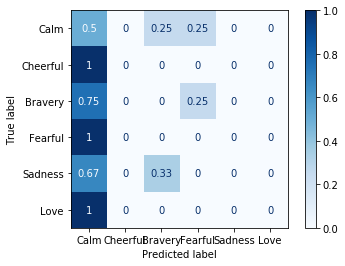

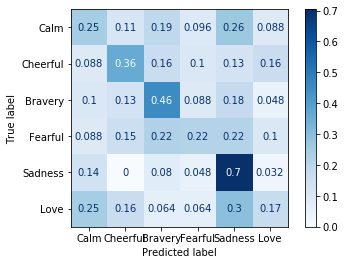

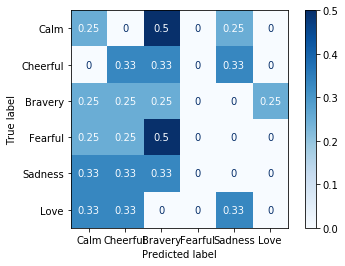

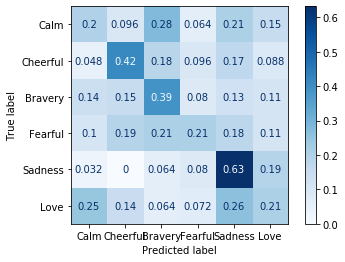

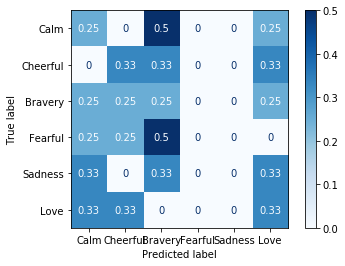

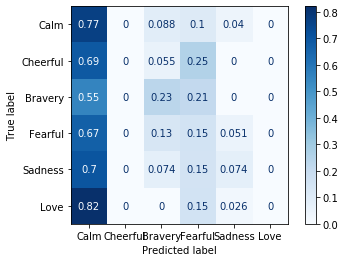

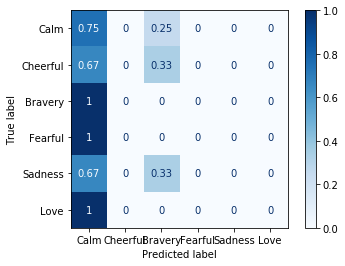

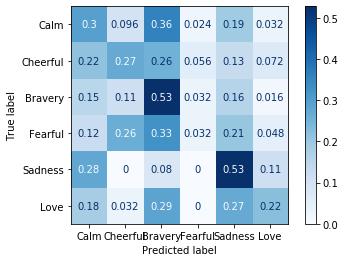

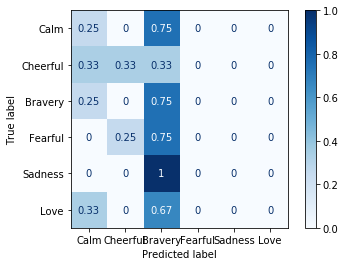

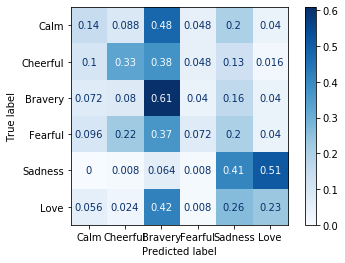

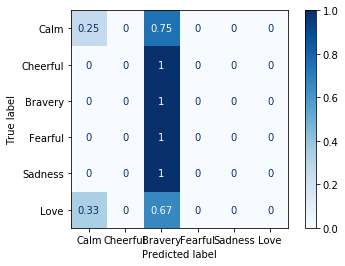

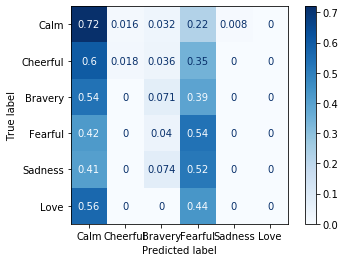

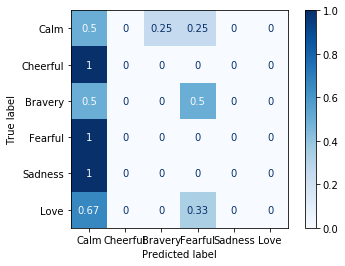

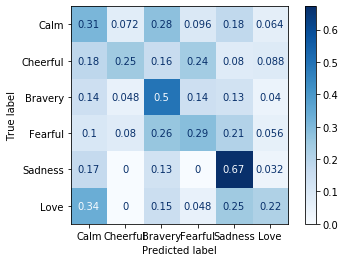

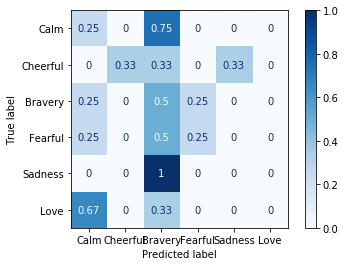

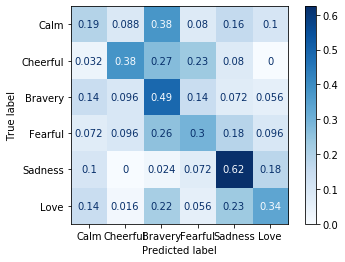

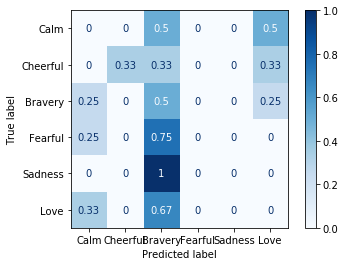

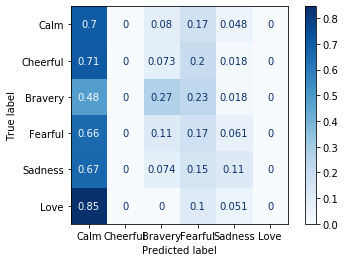

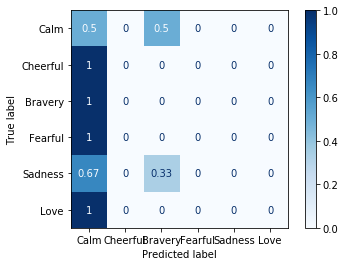

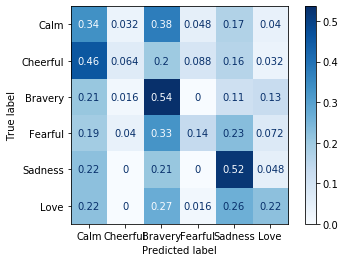

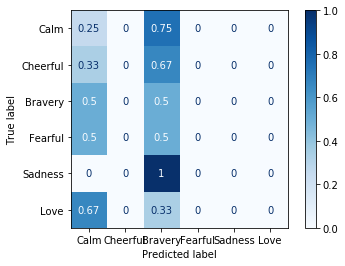

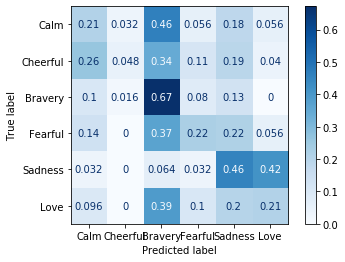

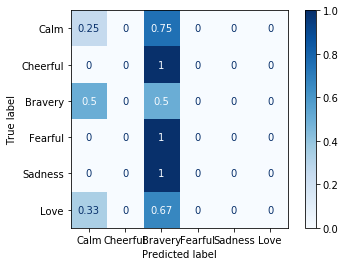

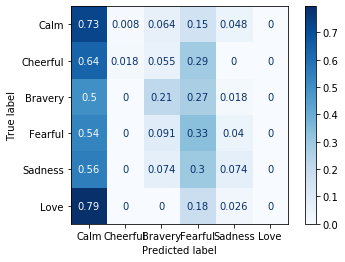

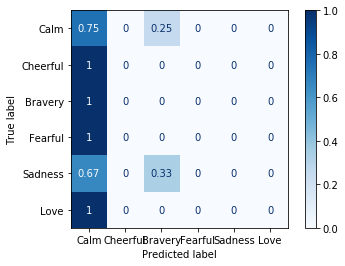

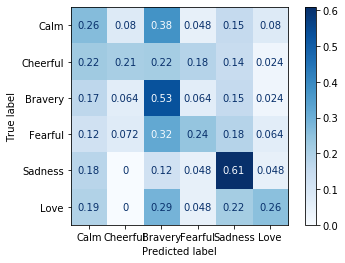

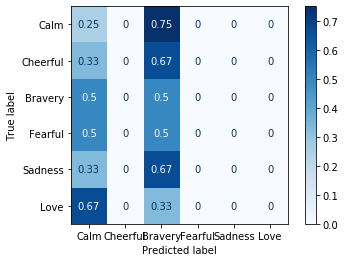

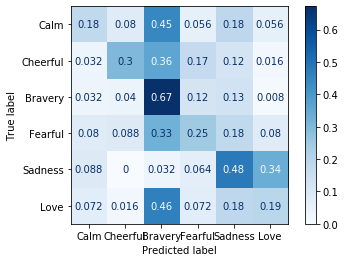

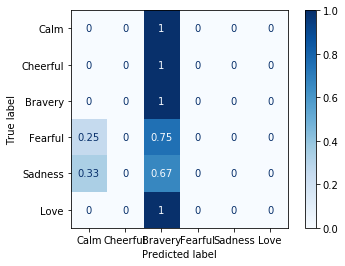

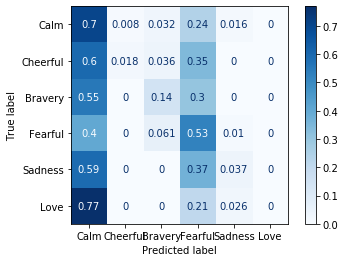

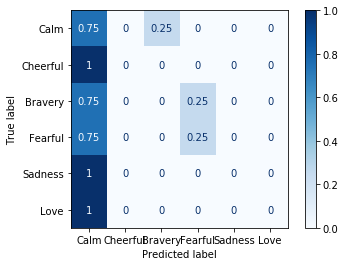

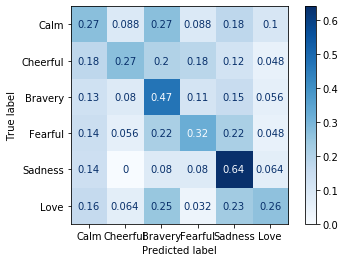

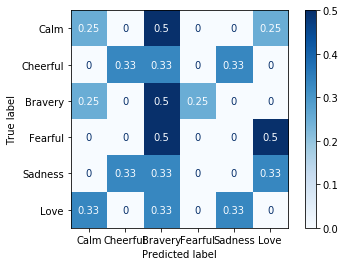

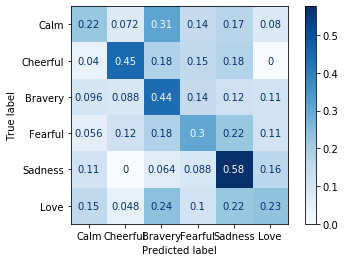

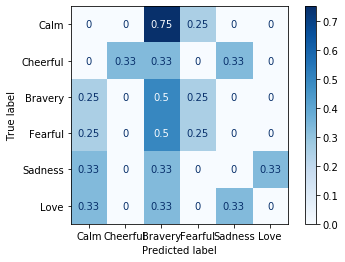

In [6]:
num_features = 45
selectors = {
    "chi2" : SelectKBest(chi2,k=num_features),
    "f_classif" : SelectKBest(f_classif,k=num_features),
    "mutual_info_classif" : SelectKBest(mutual_info_classif,k=num_features),
    "FromModel DT" : SelectFromModel(estimator=tree.DecisionTreeClassifier(random_state=481516234)),
    "RandForest" : SelectFromModel(estimator=RandomForestClassifier(n_estimators=100,random_state=481516234)),
    "LogReg" : SelectFromModel(estimator=LogisticRegression(random_state=481516234)),
    "LinearSVC" : SelectFromModel(estimator=svm.LinearSVC(C=0.25, penalty="l1", dual=False,random_state=481516234)),
}
# MultinomialNB, RandomizedSearch
random_search_iterations = 1000
k_folds = 5

parameters = {
    'alpha':uniform(loc=0,scale=1.0), 
    'fit_prior':[True, False]
}
mnb = MultinomialNB()
random_search_multinomial = RandomizedSearchCV(mnb, parameters,cv=k_folds,\
                                            n_iter=random_search_iterations,\
                                            random_state=rand_seed,n_jobs=-1)
for k,v in selectors.items():
    train_all("FinalTrainingSet.csv","Validation Set.csv",v,random_search_multinomial,k)
